### <b>Install the required libraries</b>

In [1]:
# Install the transformers library (Allows importing models from Hugging Face)
!pip install transformers
!pip install datasets 

### <b>Import necessary libraries</b>

In [2]:
import copy 
import json
import logging 
import os 

import warnings
warnings.filterwarnings("ignore")
import logging
logging.basicConfig(level=logging.ERROR)

import numpy as np
import pandas as pd
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch

In [3]:
# Check if CUDA is available
print("CUDA Available:", torch.cuda.is_available())

# If CUDA is available, print the current GPU details
if torch.cuda.is_available():
    print("Current GPU Index:", torch.cuda.current_device())
    print("Current GPU Name:", torch.cuda.get_device_name(torch.cuda.current_device()))
    print("GPU Memory Allocated:", torch.cuda.memory_allocated())
    print("GPU Memory Cached:", torch.cuda.memory_cached())

CUDA Available: True
Current GPU Index: 0
Current GPU Name: GeForce RTX 2080 Ti
GPU Memory Allocated: 0
GPU Memory Cached: 0


### <b>Load the model from Hugging Face's model hub</b>

In [4]:
import transformers
from transformers import AutoConfig, AutoModel, AutoModelForSequenceClassification, AutoTokenizer, BigBirdConfig
from transformers import AdamW, get_linear_schedule_with_warmup

In [5]:
model_path = "monologg/kobigbird-bert-base"
config = BigBirdConfig.from_pretrained(model_path, attention_type='original_full')
model = AutoModel.from_pretrained(model_path, config=config)

tokenizer = AutoTokenizer.from_pretrained(model_path)
text = "한국어 BigBird 모델을 공개합니다!"
encoded_input = tokenizer(text, return_tensors='pt', truncation=True)
output = model(**encoded_input)

In [6]:
# Print the values of the final hidden state
print(output[0])

# Print the shape of the final hidden state
print(output[0].shape)

tensor([[[ 0.0744,  0.1033, -0.4811,  ...,  0.1842, -0.3599,  0.0590],
         [-0.4572,  0.0982,  0.0485,  ..., -0.0428, -0.0085, -0.0389],
         [-0.0517,  0.2469,  0.4309,  ...,  0.1513,  0.1107,  0.5183],
         ...,
         [ 0.4131,  0.3943, -0.2341,  ...,  0.1010, -0.3778,  0.4811],
         [ 0.2193,  0.3344,  0.1173,  ...,  0.1042,  0.5646,  0.2698],
         [-0.3449,  0.2810,  0.3838,  ..., -0.2478,  0.3835,  0.4156]]],
       grad_fn=<NativeLayerNormBackward0>)
torch.Size([1, 12, 768])


### <b>Set hyperparameters for the experiment</b>

In [7]:
from types import SimpleNamespace

# Create a configuration object to store hyperparameters and other settings
config = SimpleNamespace()

config.task = "kobigbird_bias"
config.dataset = "KoMultiText"

config.cache_dir = "kobigbird_bias_cache" # Temporary directory for current task assets like vocabulary
config.output_dir = "kobigbird_bias_output" # Directory where final models and results will be saved

config.use_tpu = False
config.model_name_or_path = model_path 
config.data_dir = "./" # The input data dir 

config.train_file = "train_dataset.csv" 
config.predict_file = "test_dataset.csv" 

config.max_seq_length = 512 # Maximum sequence length
config.train_batch_size = 8 # Batch size for training
config.eval_batch_size = 4 # Batch size for evaluation

config.learning_rate = 3e-6 # The initial learning rate for Adam
config.num_train_epochs = 16 # Total number of training epochs to perform

config.gradient_accumulation_steps = 4 # Number of updates steps to accumulate before performing a backward/update pass.
config.threads = 4
config.seed = 42 

config.device_num = 0 # Device number (changable for multi-GPU setups)

config.do_train = True 
config.do_eval_during_train = True
config.do_eval = True 

config.do_lower_case = False
config.weight_decay = 0.0 # Weight decay if we apply some.
config.adam_epsilon = 1e-8 # Epsilon for Adam optimizer.
config.max_grad_norm = 1.0 # Max gradient norm.
config.warmup_proportion = 0.0 # Warmup proportion for linear warmup

### <b>Preprocessing the training dataset</b>
* Instead of tokenizing the training text every time, we preprocess and <b>save all tokenized results before starting the model training</b>.
    * This approach significantly speeds up the process.

In [8]:
tokenizer = AutoTokenizer.from_pretrained(config.model_name_or_path, do_lower_case=False, cache_dir=config.cache_dir)

In [9]:
def train_split(config, texts, labels, is_train):
    
    x_train, y_train, x_label, y_label = train_test_split(
        texts, labels, test_size=0.2, random_state=config.seed, stratify=None
    )
    if is_train:
        texts, labels = x_train, x_label
    else:
        texts, labels = y_train, y_label
        
    return texts, labels

def process_comment_cls(config, data_file, is_train):
    
    df = pd.read_csv(data_file)
    
    # Convert columns to lists for processing
    genders = df["gender"].astype(int).values.tolist()
    politics = df["politics"].astype(int).values.tolist()
    nations = df["nation"].astype(int).values.tolist()
    races = df["race"].astype(int).values.tolist()
    regions = df["region"].astype(int).values.tolist()
    generations= df["generation"].astype(int).values.tolist()
    social_clss = df["social hierarchy"].astype(int).values.tolist()
    appearences = df["appearance"].astype(int).values.tolist()
    others = df["others"].astype(int).values.tolist()
    
    # Create a combined label list
    labels = []
    for i in range(len(genders)):
        gender = genders[i] 
        politic = politics[i] 
        nation = nations[i]
        race = races[i]
        region = regions[i]
        generation = generations[i]
        social_cls = social_clss[i]
        appearence = appearences[i]
        other = others[i]
        labels.append([gender, politic, nation, race, region, generation, social_cls, appearence, other])
        
    texts = df["comment"].astype(str).values.tolist()
    texts, labels = train_split(config, texts, labels, is_train) # Split the data
    
    return texts, labels

In [10]:
import torch.utils.data as torch_data

def data_pretokenizing(config, tokenizer, is_train=True):
    if is_train:
        data_file = config.train_file
    else:
        data_file = config.predict_file

    data_path = config.data_dir
    if data_file is not None:
        data_path = os.path.join(data_path, data_file)
    else:
        data_path += "/"

    # Construct the file name for the tokenized dataset
    comps = [
        data_path,
        config.dataset,
        config.model_name_or_path.replace("/", "_"),
        config.max_seq_length,
        "train" if is_train else "dev",
        "dataset.txt",
    ]
    dataset_file = "_".join([str(comp) for comp in comps])
    print("dataset_file:", dataset_file)

    # Tokenize the dataset and write to the file
    with open(dataset_file, "w", encoding="utf-8") as writer_file:
        cnt = 0
        total_data = process_comment_cls(config, data_path, is_train)
        for text, label in zip(total_data[0], total_data[1]):
            feature = tokenizer(text, max_length=config.max_seq_length, padding="max_length", truncation=True, add_special_tokens=True)
            writed_data = {
                "input_ids": feature["input_ids"],
                "attention_mask": feature["attention_mask"],
                "gender": int(label[0]),
                "politic": int(label[1]), 
                "nation" : int(label[2]),
                "race" : int(label[3]),
                "region" : int(label[4]),
                "generation" : int(label[5]),
                "social_cls" : int(label[6]),
                "appearence" : int(label[7]),
                "other": int(label[8]),
            }
            writer_file.write(json.dumps(writed_data) + "\n")
            cnt += 1
        print(f"{cnt} features processed from {data_path}")

    return dataset_file

In [11]:
if config.do_train:
    # Preprocess the training dataset
    train_dataset_file = data_pretokenizing(config, tokenizer=tokenizer)

# Preprocess the evaluation dataset (evaluation is equivalent to 'dev' or 'validation')
predict_dataset_file = data_pretokenizing(config, tokenizer=tokenizer, is_train=False)

dataset_file: ./train_dataset.csv_KoMultiText_monologg_kobigbird-bert-base_512_train_dataset.txt
30688 features processed from ./train_dataset.csv
dataset_file: ./test_dataset.csv_KoMultiText_monologg_kobigbird-bert-base_512_dev_dataset.txt
400 features processed from ./test_dataset.csv


### <b>Initialize the data loader</b>

In [12]:
class IterableDatasetPad(torch.utils.data.IterableDataset):
    def __init__(
        self,
        dataset: torch.utils.data.IterableDataset,
        batch_size: int = 1,
        num_devices: int = 1,
        seed: int = 0,
    ):
        self.dataset = dataset
        self.batch_size = batch_size
        self.seed = seed
        self.num_examples = 0

        chunk_size = self.batch_size * num_devices
        length = len(dataset)
        self.length = length + (chunk_size - length % chunk_size)

    def __len__(self):
        return self.length

    def __iter__(self):
        self.num_examples = 0
        # If dataset has a set epoch method, set the manual seed for reproducibility
        if (
            not hasattr(self.dataset, "set_epoch")
            and hasattr(self.dataset, "generator")
            and isinstance(self.dataset.generator, torch.Generator)
        ):
            self.dataset.generator.manual_seed(self.seed + self.epoch)

        first_batch = None
        current_batch = []
        for element in self.dataset:
            self.num_examples += 1
            current_batch.append(element)
            # Wait to have a full batch before yielding elements.
            if len(current_batch) == self.batch_size:
                for batch in current_batch:
                    yield batch
                    if first_batch is None:
                        first_batch = batch.copy()
                current_batch = []
        
        # Pad the last batch if it's smaller than the batch size
        while self.num_examples < self.length:
            add_num = self.batch_size - len(current_batch)
            self.num_examples += add_num
            current_batch += [first_batch] * add_num
            for batch in current_batch:
                yield batch
            current_batch = []

In [13]:
def collate_fn(features):
    
    # Extracting individual features from samples
    input_ids = [sample["input_ids"] for sample in features]
    attention_mask = [sample["attention_mask"] for sample in features]
    
    gender = [sample["gender"] for sample in features]
    politic = [sample["politic"] for sample in features]
    nation = [sample["nation"] for sample in features]
    race = [sample["race"] for sample in features]
    region = [sample["region"] for sample in features]
    generation = [sample["generation"] for sample in features]
    social_cls = [sample["social_cls"] for sample in features]
    appearence = [sample["appearence"] for sample in features]
    other = [sample["other"] for sample in features]
    
    # Convert lists to tensors
    input_ids = torch.tensor(np.array(input_ids).astype(np.int64), dtype=torch.long)
    attention_mask = torch.tensor(np.array(attention_mask).astype(np.int8), dtype=torch.long)
    
    gender = torch.tensor(np.array(gender).astype(np.int64), dtype=torch.float)
    politic = torch.tensor(np.array(politic).astype(np.int64), dtype=torch.float)
    nation = torch.tensor(np.array(nation).astype(np.int64), dtype=torch.float)
    race = torch.tensor(np.array(race).astype(np.int64), dtype=torch.float)
    region = torch.tensor(np.array(region).astype(np.int64), dtype=torch.float)
    generation = torch.tensor(np.array(generation).astype(np.int64), dtype=torch.float)
    social_cls = torch.tensor(np.array(social_cls).astype(np.int64), dtype=torch.float)
    appearence = torch.tensor(np.array(appearence).astype(np.int64), dtype=torch.float)
    other = torch.tensor(np.array(other).astype(np.int64), dtype=torch.float)
    
    inputs = {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
    }
    labels = {
        "gender" : gender,
        "politic": politic,
        "nation" :nation, 
        "race" : race,
        "region" : region,
        "generation" : generation,
        "social_cls" : social_cls,
        "appearence" : appearence,
        "other" : other,
    }
    return inputs, labels

if config.do_train:
    train_dataset = load_dataset("text", data_files=train_dataset_file, download_mode="force_redownload")["train"]
    train_dataset = train_dataset.map(lambda x: json.loads(x["text"]), batched=False)

    train_dataloader = torch_data.DataLoader(
        train_dataset,
        sampler=torch_data.RandomSampler(train_dataset),
        drop_last=False,
        batch_size=config.train_batch_size,
        collate_fn=(collate_fn),
    )

predict_dataset = load_dataset("text", data_files=predict_dataset_file, download_mode="force_redownload")["train"]
predict_dataset = predict_dataset.map(lambda x: json.loads(x["text"]), batched=False)
predict_dataset = IterableDatasetPad(
    dataset=predict_dataset,
    batch_size=config.eval_batch_size,
    num_devices=1,
    seed=config.seed,
)

predict_dataloader = torch_data.DataLoader(
    predict_dataset,
    sampler=None,
    drop_last=False,
    batch_size=config.eval_batch_size,
    collate_fn=(collate_fn),
)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset text downloaded and prepared to /home/dasol/.cache/huggingface/datasets/text/default-9742c5c8b3b409fb/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/30688 [00:00<?, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset text downloaded and prepared to /home/dasol/.cache/huggingface/datasets/text/default-93413c98e2a7b8fa/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

### <b>Define the text classification model</b>

In [14]:
from transformers import AutoModel
import torch.nn as nn

class ClsModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        data_file = os.path.join(config.data_dir, str(config.train_file))  # (전처리된) 학습할 데이터 세트의 경로 설정
        model_config = AutoConfig.from_pretrained(config.model_name_or_path, num_labels=5)
        self.model = AutoModel.from_pretrained(
            config.model_name_or_path, config=model_config, cache_dir=config.cache_dir
        )
        
        self.activation = nn.ReLU()
        
        # Initialize multiple classifiers (linear layers) for multi-label
        self.classifiers = nn.ModuleList([nn.Linear(768, size) for size in [1, 1, 1, 1, 1, 1, 1, 1, 1]])

        self.tokenizer = tokenizer

    def save_pretrained(self, save_dir):
        self.model.save_pretrained(save_dir)
        # Remove unnecessary keys from the tokenizer's init_kwargs
        for key in ["special_tokens_map_file", "tokenizer_file"]:
            self.tokenizer.init_kwargs.pop(key, None)
        self.tokenizer.save_pretrained(save_dir)

    def get_optimizer(self): 
        # Specify parameters that should not undergo weight decay during training
        no_decay = ["bias", "LayerNorm.weight"]
        # Group model parameters based on whether they should have weight decay or not
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": config.weight_decay,
            },
            {
                "params": [p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": config.weight_decay,
            },
        ]
        
        optimizer = AdamW(optimizer_grouped_parameters, lr=config.learning_rate, eps=config.adam_epsilon)
        return optimizer

    def get_scheduler(self, batch_num, optimizer): 
        # If no warmup is needed, return None
        if config.warmup_proportion == 0.0:
            return None
        
        # Calculate the total number of training steps
        t_total = batch_num // config.gradient_accumulation_steps * config.num_train_epochs
        
        # Define the learning rate scheduler with a linear warmup phase
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int(t_total * config.warmup_proportion),
            num_training_steps=t_total,
        )

        return scheduler

    def forward(self, inputs):
        hidden = self.model(**inputs) # Get the model's hidden states
        # Extract [CLS] token from the last layer
        cls_token_embeddings = hidden.last_hidden_state[:,0,:] # [batch_size, 768]
        
        # Get outputs for each task using the respective classifier
        outputs = [classifier(cls_token_embeddings) for classifier in self.classifiers]

        return outputs
    

    def eval_step(self, inputs, labels, outputs):

        label_keys = ["gender", "politic", "nation", "race", "region", "generation", "social_cls", "appearence", "other"]
        results = {}
        threshold = 0.5

        for idx, key in enumerate(label_keys):
            logits = outputs[idx].detach().cpu()
            actual_labels = self.tensor_to_list(labels[key])
            predictions = self.tensor_to_list((torch.sigmoid(logits) > threshold).int())

            results[f"results_{idx+1}"] = [{
                "prediction": prediction,
                "label": label,
                "prob": torch.sigmoid(prob).item()
            } for prediction, label, prob in zip(predictions, actual_labels, logits)]

        return results
    
    def tensor_to_array(self, tensor):
        return tensor.detach().cpu().numpy()
    
    def tensor_to_list(self, tensor):
        return self.tensor_to_array(tensor).tolist()

In [15]:
# Set the random seed for reproducibility in both numpy and PyTorch
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

# Calculate the running average of the loss using a decay factor
def cal_running_avg_loss(loss, running_avg_loss, decay=0.99):
    if running_avg_loss == 0:
        return loss
    running_avg_loss = running_avg_loss * decay + (1 - decay) * loss
    return running_avg_loss

### <b>Define the functions for training and evaluation</b>

In [16]:
from functools import partial
import sklearn.metrics as sklearn_metrics
from sklearn.metrics import f1_score, precision_recall_curve, auc, roc_curve
import matplotlib.pyplot as plt

category_map = {
    1: "gender",
    2: "politic",
    3: "nation",
    4: "race",
    5: "region",
    6: "generation",
    7: "social hierarchy",
    8: "appearence",
    9: "other"
}

# for binary-classification
binary_metrics = {
    "accuracy": sklearn_metrics.accuracy_score,
    "precision": sklearn_metrics.precision_score, # TP / (TP + FP)
    "recall": sklearn_metrics.recall_score, # recall = sensitivity (민감도)
    "f1": sklearn_metrics.f1_score,
    "matthews_corrcoef": sklearn_metrics.matthews_corrcoef,
}

# Function to calculate the area under the Precision-Recall curve.
def calculate_pr_auc(labels, prob):
    precision, recall, _ = precision_recall_curve(labels, prob)
    return auc(recall, precision)

# General function to plot either the ROC or Precision-Recall curve for multiple categories.
def plot_curve(labels_list, probs_list, category_names, curve_type="auroc"):
    plt.figure(figsize=(10, 6))
    for labels, probs, category_name in zip(labels_list, probs_list, category_names):
        if curve_type == "auroc":
            x, y, _ = roc_curve(labels, probs)
            metric = auc(x, y)
            xlabel, ylabel, title = 'False Positive Rate', 'True Positive Rate', 'ROC Curves for Bias Labels'
        else:
            x, y, _ = precision_recall_curve(labels, probs)
            metric = auc(y, x)
            xlabel, ylabel, title = 'Recall', 'Precision', 'Precision-Recall Curves for Bias Labels'
        
        plt.plot(x, y, lw=2, label=f'{category_name} (AUC = {metric:.2f})')

    if curve_type == "auroc":
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.title(title, fontsize=19)
    plt.legend(loc='lower right' if curve_type == "auroc" else 'lower left', fontsize=14)
    plt.show()


# Evaluate the performance of the model based on various metrics    
def eval_cls(all_results, all_probs, **kwargs):
    
    results_dict = {}
    category_names = []
    
    labels_list = []  
    probs_list = []   
    
    for i in range(9):
        results_i = all_results[i]
        probs_i = all_probs[i]

        predictions = np.array([result["prediction"] for result in results_i])
        labels = np.array([result["label"] for result in results_i])

        y_scores = np.array([prob[1] if prob.shape[0] > 1 else prob[0] for prob in probs_i])

        labels_list.append(labels)
        probs_list.append(y_scores)

        metric_funcs = binary_metrics
        results = {metric: round(f(labels, predictions) * 100, 2) for metric, f in metric_funcs.items()}  # This line initializes the 'results' dictionary.

        results["pr_auc"] = calculate_pr_auc(labels, y_scores)
        results["roc_auc"] = sklearn_metrics.roc_auc_score(labels, y_scores)
        results_dict[f"pr_auc_{i+1}"] = results["pr_auc"]
        results_dict[f"roc_auc{i+1}"] = results["roc_auc"]

        category_name = category_map.get(i+1, f"Category {i+1}")
        category_names.append(category_name)

        results_dict[f"results_{i+1}"] = results
        
    # Plot the ROC and PRROC curves for all bias tasks
    plot_curve(labels_list, probs_list, category_names)
    plot_curve(labels_list, probs_list, category_names, curve_type="prroc")
    
    return results_dict

In [17]:
def _run_epoch(model, loader, device=None, context=None, **kwargs):
    
    config = kwargs["config"]
    is_train = kwargs["is_train"]

    avg_loss = 0
    results = []
    batch_num = len(loader)

    if is_train:
        model.train()
        if config.use_tpu:
            optimizer = context.getattr_or(
                "optimizer",
                lambda: model.get_optimizer(),
            )
            scheduler = context.getattr_or(
                "scheduler",
                lambda: model.get_scheduler(batch_num, optimizer),
            )
        else:
            optimizer = kwargs["optimizer"]
            scheduler = kwargs["scheduler"]
    else:
        model.eval()
        
    # ProgressBar setup
    is_master = True
    pbar = tqdm(enumerate(loader), total=batch_num, disable=not is_master, dynamic_ncols=True, position=0, leave=True)

    corrections = [0] * 9
    total = 0
    
    for i, (inputs, labels) in pbar:
        # Move tensors to device
        inputs = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in inputs.items()}
        labels = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in labels.items()}

        outputs = model(inputs)

        threshold = 0.5
        weights_bias = [1, 10.0, 20.0]
        weights_final = [1, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2]
        total += outputs[0].shape[0]  # batch_size
        
        label_keys = ["gender", "politic", "nation", "race", "region", "generation", "social_cls", "appearence", "other"]

        # Define loss functions
        weight1 = torch.tensor([10.0]).to(device)
        weight2 = torch.tensor([30.0]).to(device)
        loss_with_w1 = nn.BCEWithLogitsLoss(pos_weight=weight1)
        loss_with_w2 = nn.BCEWithLogitsLoss(pos_weight=weight2)
        
        total_loss = 0
        corrections = []

        for idx, key in enumerate(label_keys):
            output = outputs[idx].squeeze(1)
            label = labels[key]
            predicted = torch.sigmoid(output) >= threshold
            correct = predicted.eq(label).sum().item()
            corrections.append(correct)

            # Loss computation
            if idx == 0:
                loss = loss_with_w1(output, label)
            else:
                loss = loss_with_w2(output, label)
            total_loss += weights_final[idx] * loss

        avg_loss = cal_running_avg_loss(total_loss.item(), avg_loss)
        total_loss /= config.gradient_accumulation_steps

        if is_train:
            total_loss.backward()
            if i % config.gradient_accumulation_steps == 0 or i == batch_num - 1:
                if config.max_grad_norm > 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)

                optimizer.step()
                optimizer.zero_grad()

                if scheduler is not None:
                    scheduler.step()
        else:
            result = (model.module if hasattr(model, "module") else model).eval_step(inputs, labels, outputs)
            results.append(result)

        if is_master:
            pbar.set_description(
                f"epoch: {kwargs['epoch'] + 1}, {('train' if is_train else 'valid')} loss: {min(100, round(avg_loss, 4))}"
            )

    return {
        "loss": avg_loss,
        "result": results,
    }

def run_epoch(**kwargs):
    model = kwargs.pop("model")
    if kwargs["config"].use_tpu:
        results = model(_run_epoch, **kwargs)
    else:
        results = _run_epoch(model, **kwargs)
   
    if isinstance(results, list):
        loss = sum([result["loss"] for result in results]) / len(results)
        result = []
        for res in results:
            result.extend(res["result"])
        results = {"loss": loss, "result": result}

    return results

### <b>Model Initialization and Configuration</b>

In [18]:
set_seed(config.seed) # Set the random seed for reproducibility

model = ClsModel()  # Initialize the classification model

print(f"configuration: {str(config)}")

# Check for available GPUs and set the model to run on GPU(s) if available
if torch.cuda.is_available():
    gpu_count = torch.cuda.device_count()
    print(f"{gpu_count} GPU device detected")
    device_num = config.device_num
    devices = [device_num]
    # Use Data Parallelism if more than one GPU is available
    model_dp = torch.nn.DataParallel(model, device_ids=devices) # If no GPUs are available, use the CPU
    model_dp.to(devices[0])     
else: 
    devices = ["cpu"]
    model_dp = model

# Create cache directory if it doesn't exist
if not os.path.exists(config.cache_dir):
    os.makedirs(config.cache_dir)

# Define and create the output directory
output_dir = os.path.join(config.output_dir, config.task, config.dataset)
print("Output directory:", output_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Initialize optimizer and scheduler if in training mode
optimizer = None
scheduler = None
if config.do_train: # 학습 모드(train mode)인 경우
    optimizer = model.get_optimizer()
    scheduler = model.get_scheduler(len(train_dataloader), optimizer)

params = {
    "config": config,
    "model": model_dp,
    "optimizer": optimizer,
    "scheduler": scheduler,
}
if not config.use_tpu:
    params["device"] = devices[0]

configuration: namespace(task='kobigbird_bias', dataset='KoMultiText', cache_dir='kobigbird_bias_cache', output_dir='kobigbird_bias_output', use_tpu=False, model_name_or_path='monologg/kobigbird-bert-base', data_dir='./', train_file='train_dataset.csv', predict_file='test_dataset.csv', max_seq_length=512, train_batch_size=8, eval_batch_size=4, learning_rate=3e-06, num_train_epochs=16, gradient_accumulation_steps=4, threads=4, seed=42, device_num=1, do_train=True, do_eval_during_train=True, do_eval=True, do_lower_case=False, weight_decay=0.0, adam_epsilon=1e-08, max_grad_norm=1.0, warmup_proportion=0.0)
4 GPU device detected
Output directory: kobigbird_bias_output/kobigbird_bias/KoMultiText


### <b>Traning the model</b>

epoch: 1, valid loss: 12.9888: 100%|██████████| 101/101 [00:08<00:00, 11.54it/s]


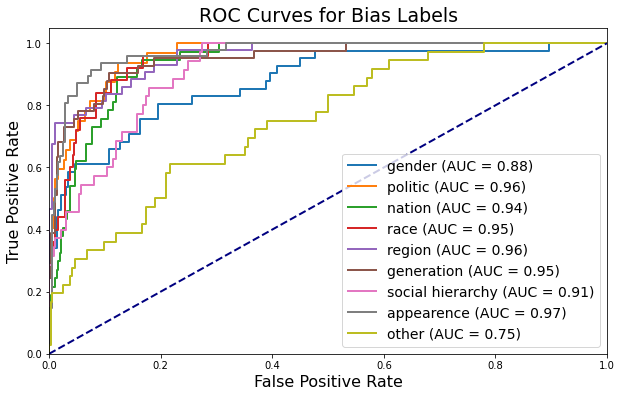

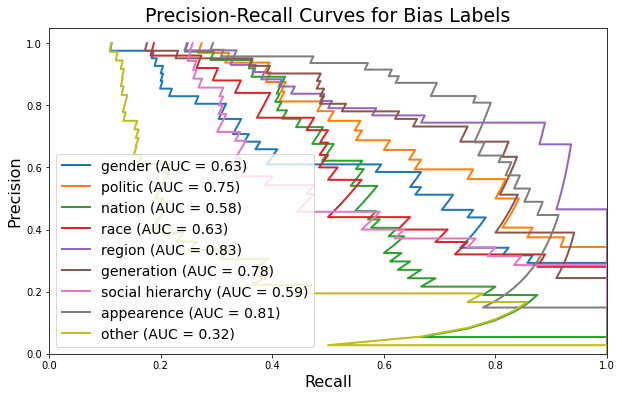


Eval results for gender.
accuracy : 75.99
precision : 27.05
recall : 80.49
f1 : 40.49
matthews_corrcoef : 36.81
pr_auc : 0.6310319314694278
roc_auc : 0.8759658670966874

Eval results for politic.
accuracy : 67.08
precision : 19.39
recall : 100.0
f1 : 32.49
matthews_corrcoef : 35.3
pr_auc : 0.7458273944617337
roc_auc : 0.961021505376344

Eval results for nation.
accuracy : 74.75
precision : 26.28
recall : 97.3
f1 : 41.38
matthews_corrcoef : 42.51
pr_auc : 0.5818013865269283
roc_auc : 0.9380661315266219

Eval results for race.
accuracy : 66.09
precision : 15.43
recall : 100.0
f1 : 26.74
matthews_corrcoef : 31.39
pr_auc : 0.6346555332927456
roc_auc : 0.9510290237467018

Eval results for region.
accuracy : 78.22
precision : 32.56
recall : 97.67
f1 : 48.84
matthews_corrcoef : 48.67
pr_auc : 0.8306951531778014
roc_auc : 0.9569670811054565

Eval results for generation.
accuracy : 82.67
precision : 36.45
recall : 95.12
f1 : 52.7
matthews_corrcoef : 52.28
pr_auc : 0.7762028722560438
roc_auc : 

epoch: 2, valid loss: 11.2643: 100%|██████████| 101/101 [00:08<00:00, 11.46it/s]


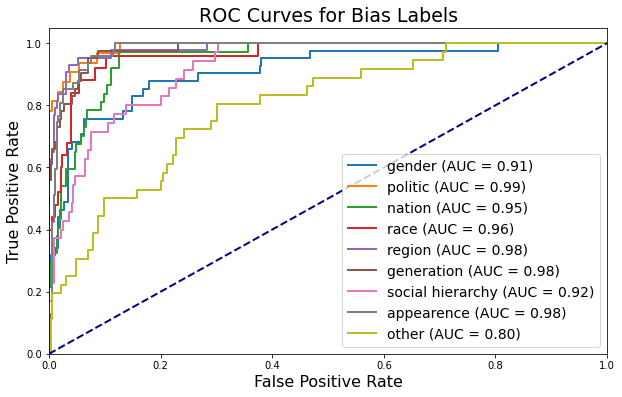

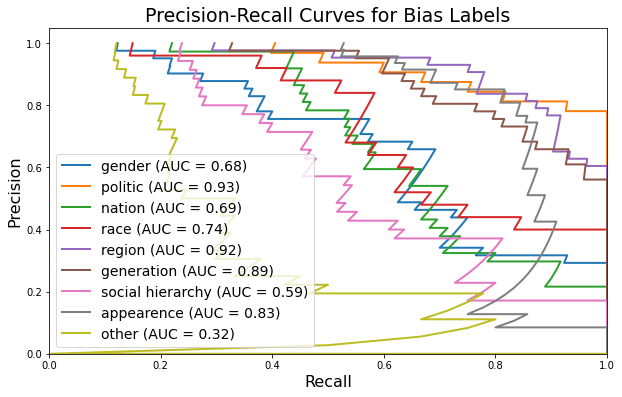


Eval results for gender.
accuracy : 86.39
precision : 40.79
recall : 75.61
f1 : 52.99
matthews_corrcoef : 48.84
pr_auc : 0.6794007736614762
roc_auc : 0.9107706779547134

Eval results for politic.
accuracy : 77.48
precision : 26.02
recall : 100.0
f1 : 41.29
matthews_corrcoef : 44.33
pr_auc : 0.9266139309973156
roc_auc : 0.9890793010752688

Eval results for nation.
accuracy : 86.63
precision : 40.45
recall : 97.3
f1 : 57.14
matthews_corrcoef : 57.66
pr_auc : 0.6932269498912706
roc_auc : 0.9527947566094704

Eval results for race.
accuracy : 81.68
precision : 24.74
recall : 96.0
f1 : 39.34
matthews_corrcoef : 43.29
pr_auc : 0.7373900510155463
roc_auc : 0.9640105540897097

Eval results for region.
accuracy : 94.06
precision : 65.08
recall : 95.35
f1 : 77.36
matthews_corrcoef : 75.87
pr_auc : 0.9215088827274173
roc_auc : 0.9845390710558526

Eval results for generation.
accuracy : 89.36
precision : 48.78
recall : 97.56
f1 : 65.04
matthews_corrcoef : 64.56
pr_auc : 0.889311300774529
roc_auc :

epoch: 3, valid loss: 12.2875: 100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


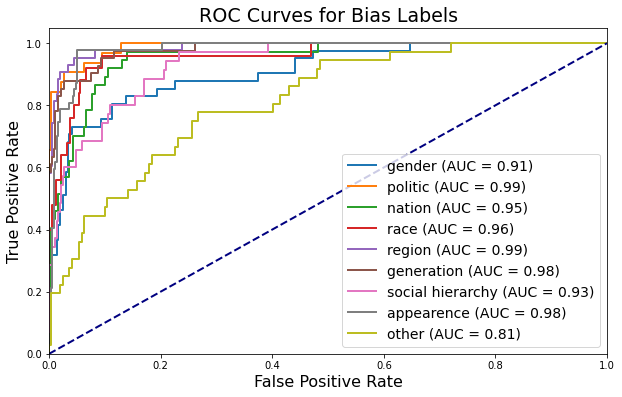

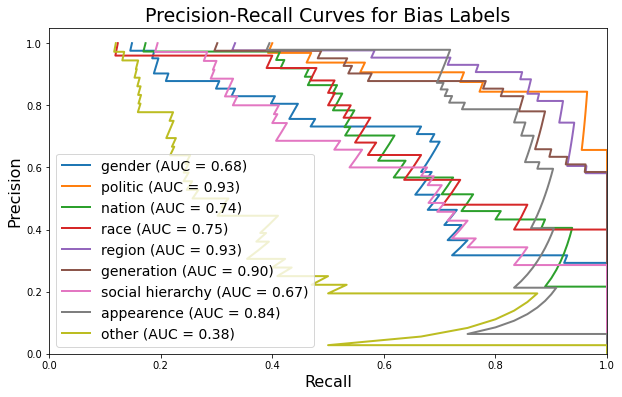


Eval results for gender.
accuracy : 90.84
precision : 53.57
recall : 73.17
f1 : 61.86
matthews_corrcoef : 57.68
pr_auc : 0.6849391407210946
roc_auc : 0.9096284351273265

Eval results for politic.
accuracy : 87.13
precision : 38.1
recall : 100.0
f1 : 55.17
matthews_corrcoef : 57.25
pr_auc : 0.9280398890451366
roc_auc : 0.9890793010752688

Eval results for nation.
accuracy : 87.38
precision : 41.46
recall : 91.89
f1 : 57.14
matthews_corrcoef : 56.52
pr_auc : 0.7351562877376647
roc_auc : 0.9540466897415125

Eval results for race.
accuracy : 87.87
precision : 33.33
recall : 96.0
f1 : 49.48
matthews_corrcoef : 52.47
pr_auc : 0.7471059854876045
roc_auc : 0.9612664907651716

Eval results for region.
accuracy : 96.04
precision : 76.47
recall : 90.7
f1 : 82.98
matthews_corrcoef : 81.13
pr_auc : 0.934082045647824
roc_auc : 0.9877600979192167

Eval results for generation.
accuracy : 92.08
precision : 56.92
recall : 90.24
f1 : 69.81
matthews_corrcoef : 67.83
pr_auc : 0.9000262354228369
roc_auc : 

epoch: 4, valid loss: 10.4448: 100%|██████████| 101/101 [00:08<00:00, 11.42it/s]


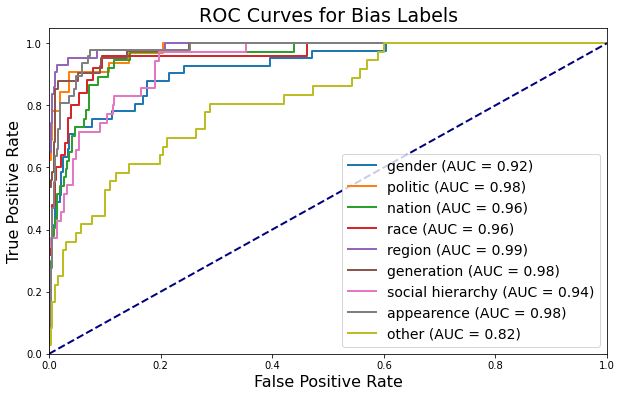

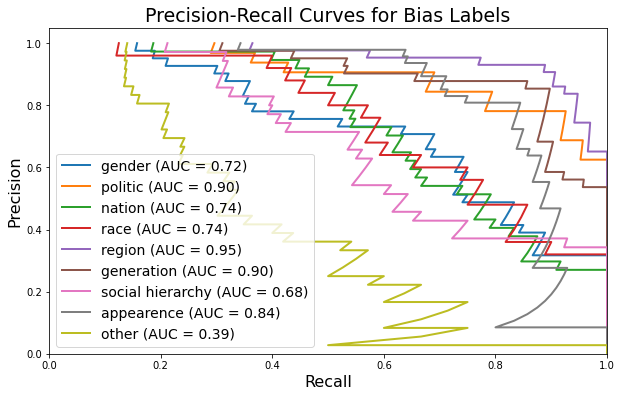


Eval results for gender.
accuracy : 90.1
precision : 50.82
recall : 75.61
f1 : 60.78
matthews_corrcoef : 56.8
pr_auc : 0.7224376385542155
roc_auc : 0.9234697305650742

Eval results for politic.
accuracy : 87.87
precision : 38.96
recall : 93.75
f1 : 55.05
matthews_corrcoef : 55.77
pr_auc : 0.8967900893666637
roc_auc : 0.9817708333333333

Eval results for nation.
accuracy : 89.6
precision : 46.48
recall : 89.19
f1 : 61.11
matthews_corrcoef : 59.74
pr_auc : 0.7399981517860661
roc_auc : 0.9571397010089109

Eval results for race.
accuracy : 89.6
precision : 36.92
recall : 96.0
f1 : 53.33
matthews_corrcoef : 55.86
pr_auc : 0.7429512873433732
roc_auc : 0.9612664907651715

Eval results for region.
accuracy : 96.78
precision : 80.0
recall : 93.02
f1 : 86.02
matthews_corrcoef : 84.52
pr_auc : 0.9529049316705492
roc_auc : 0.990594601558977

Eval results for generation.
accuracy : 94.06
precision : 65.45
recall : 87.8
f1 : 75.0
matthews_corrcoef : 72.71
pr_auc : 0.9022775281423424
roc_auc : 0.981

epoch: 5, valid loss: 9.4193: 100%|███████████| 101/101 [00:09<00:00, 10.99it/s]


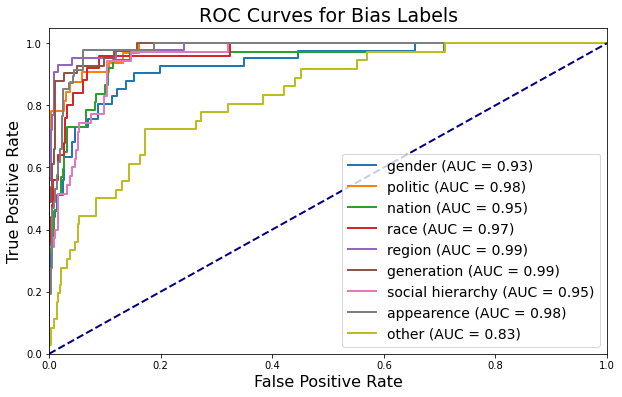

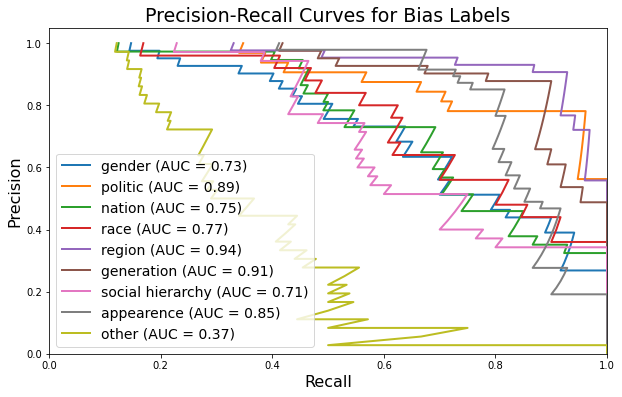


Eval results for gender.
accuracy : 87.87
precision : 44.74
recall : 82.93
f1 : 58.12
matthews_corrcoef : 55.14
pr_auc : 0.734792948227255
roc_auc : 0.9319357656386481

Eval results for politic.
accuracy : 93.07
precision : 53.7
recall : 90.62
f1 : 67.44
matthews_corrcoef : 66.59
pr_auc : 0.8903223600951135
roc_auc : 0.9821068548387095

Eval results for nation.
accuracy : 89.36
precision : 45.83
recall : 89.19
f1 : 60.55
matthews_corrcoef : 59.21
pr_auc : 0.7512021009165167
roc_auc : 0.949628102216658

Eval results for race.
accuracy : 88.61
precision : 34.78
recall : 96.0
f1 : 51.06
matthews_corrcoef : 53.86
pr_auc : 0.771475673110707
roc_auc : 0.9696042216358839

Eval results for region.
accuracy : 95.54
precision : 72.73
recall : 93.02
f1 : 81.63
matthews_corrcoef : 79.92
pr_auc : 0.9439533086834915
roc_auc : 0.9884043032918894

Eval results for generation.
accuracy : 94.55
precision : 67.27
recall : 90.24
f1 : 77.08
matthews_corrcoef : 75.1
pr_auc : 0.9103410416820198
roc_auc : 0.

epoch: 6, valid loss: 9.4101: 100%|███████████| 101/101 [00:09<00:00, 11.15it/s]


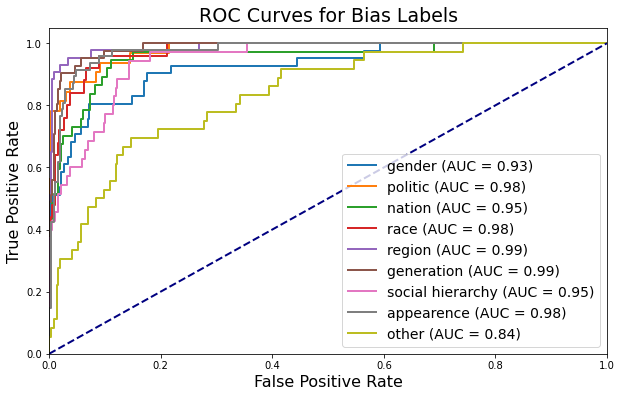

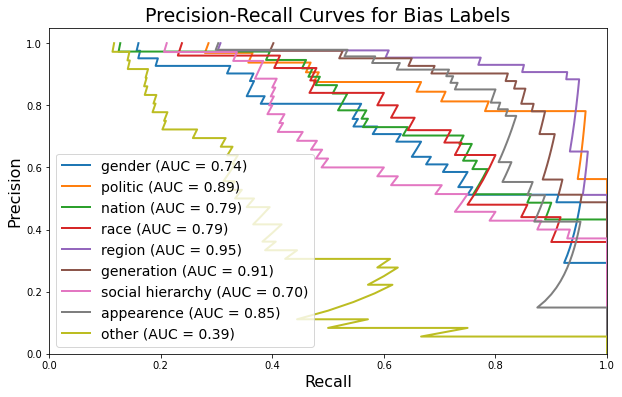


Eval results for gender.
accuracy : 91.34
precision : 55.56
recall : 73.17
f1 : 63.16
matthews_corrcoef : 59.06
pr_auc : 0.7449213228721812
roc_auc : 0.926090169992609

Eval results for politic.
accuracy : 90.84
precision : 46.15
recall : 93.75
f1 : 61.86
matthews_corrcoef : 61.99
pr_auc : 0.8883414104547114
roc_auc : 0.9800067204301075

Eval results for nation.
accuracy : 89.85
precision : 47.22
recall : 91.89
f1 : 62.39
matthews_corrcoef : 61.45
pr_auc : 0.7900149108071657
roc_auc : 0.9542676191177554

Eval results for race.
accuracy : 88.86
precision : 35.29
recall : 96.0
f1 : 51.61
matthews_corrcoef : 54.34
pr_auc : 0.7869862020462959
roc_auc : 0.975514511873351

Eval results for region.
accuracy : 96.53
precision : 78.43
recall : 93.02
f1 : 85.11
matthews_corrcoef : 83.55
pr_auc : 0.9453887659731134
roc_auc : 0.9889196675900277

Eval results for generation.
accuracy : 95.05
precision : 69.81
recall : 90.24
f1 : 78.72
matthews_corrcoef : 76.78
pr_auc : 0.9096286606831255
roc_auc :

epoch: 7, valid loss: 9.7654: 100%|███████████| 101/101 [00:08<00:00, 11.70it/s]


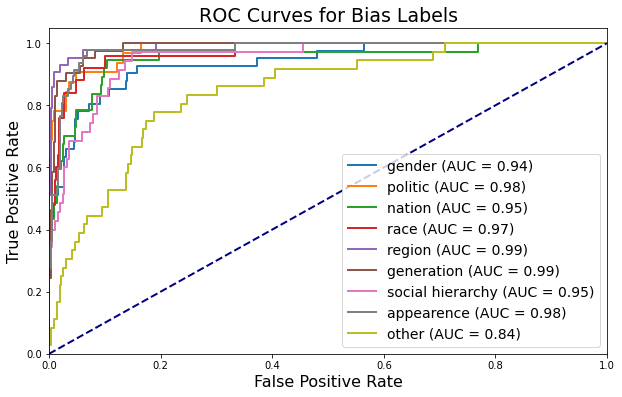

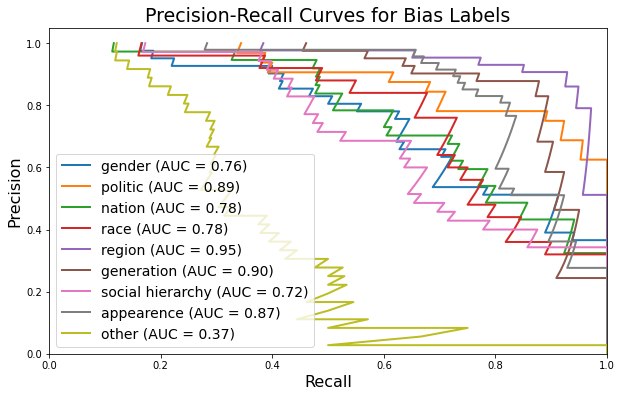


Eval results for gender.
accuracy : 89.11
precision : 47.89
recall : 82.93
f1 : 60.71
matthews_corrcoef : 57.71
pr_auc : 0.7621336132545519
roc_auc : 0.9379157427937915

Eval results for politic.
accuracy : 89.85
precision : 43.28
recall : 90.62
f1 : 58.59
matthews_corrcoef : 58.39
pr_auc : 0.8892763190054473
roc_auc : 0.9817708333333333

Eval results for nation.
accuracy : 90.35
precision : 48.53
recall : 89.19
f1 : 62.86
matthews_corrcoef : 61.41
pr_auc : 0.775816982768454
roc_auc : 0.9503645334708005

Eval results for race.
accuracy : 90.35
precision : 38.71
recall : 96.0
f1 : 55.17
matthews_corrcoef : 57.47
pr_auc : 0.7757200349361595
roc_auc : 0.9710817941952506

Eval results for region.
accuracy : 96.78
precision : 80.0
recall : 93.02
f1 : 86.02
matthews_corrcoef : 84.52
pr_auc : 0.9518394260045777
roc_auc : 0.9913676480061844

Eval results for generation.
accuracy : 93.56
precision : 61.9
recall : 95.12
f1 : 75.0
matthews_corrcoef : 73.67
pr_auc : 0.8952465986370004
roc_auc : 0

epoch: 8, valid loss: 10.4916: 100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


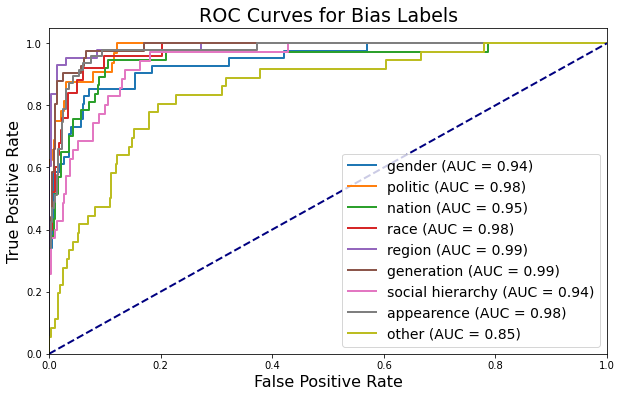

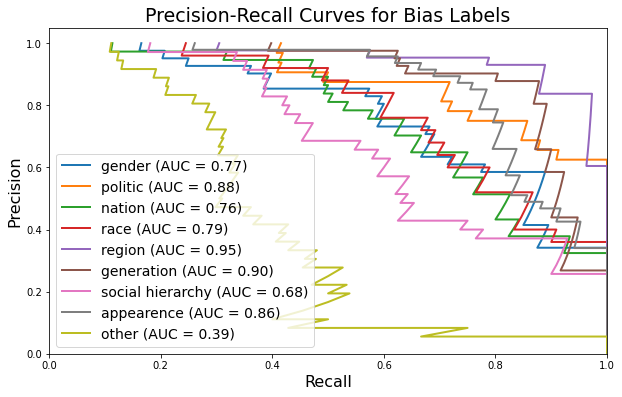


Eval results for gender.
accuracy : 89.85
precision : 50.0
recall : 85.37
f1 : 63.06
matthews_corrcoef : 60.42
pr_auc : 0.7722983112502888
roc_auc : 0.9417456158032654

Eval results for politic.
accuracy : 89.11
precision : 41.43
recall : 90.62
f1 : 56.86
matthews_corrcoef : 56.8
pr_auc : 0.878744139956074
roc_auc : 0.9821908602150538

Eval results for nation.
accuracy : 90.59
precision : 49.25
recall : 89.19
f1 : 63.46
matthews_corrcoef : 61.98
pr_auc : 0.7638102632342146
roc_auc : 0.9485970984608587

Eval results for race.
accuracy : 91.09
precision : 40.35
recall : 92.0
f1 : 56.1
matthews_corrcoef : 57.47
pr_auc : 0.7864399891543462
roc_auc : 0.976042216358839

Eval results for region.
accuracy : 97.28
precision : 83.33
recall : 93.02
f1 : 87.91
matthews_corrcoef : 86.55
pr_auc : 0.9507124340288531
roc_auc : 0.9890485086645622

Eval results for generation.
accuracy : 94.06
precision : 64.91
recall : 90.24
f1 : 75.51
matthews_corrcoef : 73.5
pr_auc : 0.8950627978057644
roc_auc : 0.9

epoch: 9, valid loss: 10.0192: 100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


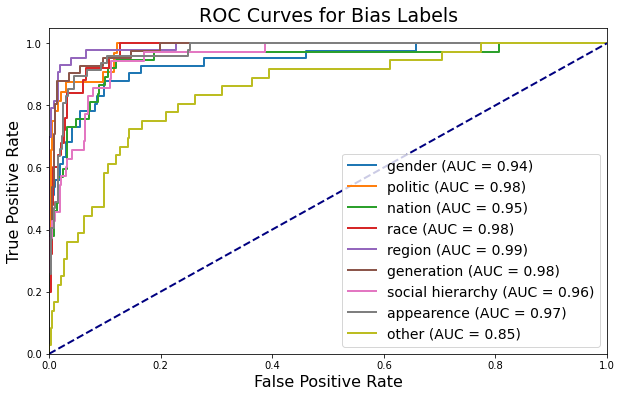

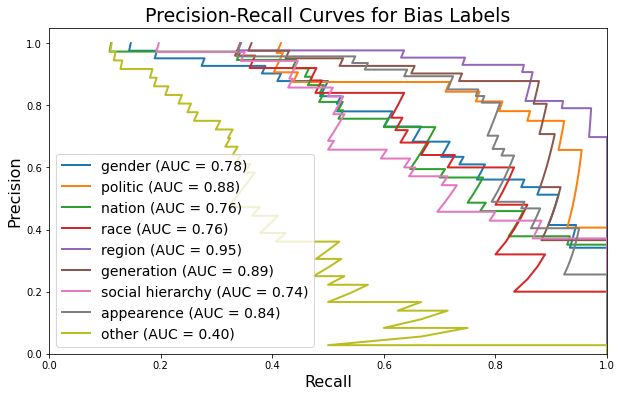


Eval results for gender.
accuracy : 92.33
precision : 59.26
recall : 78.05
f1 : 67.37
matthews_corrcoef : 63.88
pr_auc : 0.7765300132385408
roc_auc : 0.9405361822213264

Eval results for politic.
accuracy : 91.58
precision : 48.28
recall : 87.5
f1 : 62.22
matthews_corrcoef : 61.18
pr_auc : 0.8790390357494762
roc_auc : 0.982358870967742

Eval results for nation.
accuracy : 90.59
precision : 49.18
recall : 81.08
f1 : 61.22
matthews_corrcoef : 58.51
pr_auc : 0.7571994368494949
roc_auc : 0.9467560203255027

Eval results for race.
accuracy : 89.85
precision : 37.1
recall : 92.0
f1 : 52.87
matthews_corrcoef : 54.62
pr_auc : 0.7575240184487855
roc_auc : 0.977203166226913

Eval results for region.
accuracy : 96.78
precision : 80.0
recall : 93.02
f1 : 86.02
matthews_corrcoef : 84.52
pr_auc : 0.9490110940959577
roc_auc : 0.9898215551117695

Eval results for generation.
accuracy : 95.54
precision : 72.55
recall : 90.24
f1 : 80.43
matthews_corrcoef : 78.55
pr_auc : 0.888582957114793
roc_auc : 0.9

epoch: 10, valid loss: 10.4424: 100%|█████████| 101/101 [00:09<00:00, 11.17it/s]


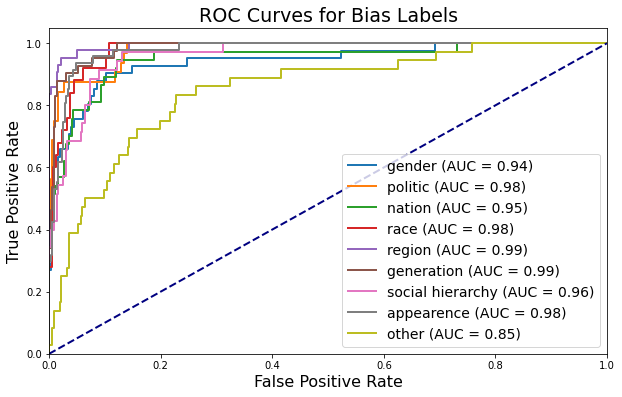

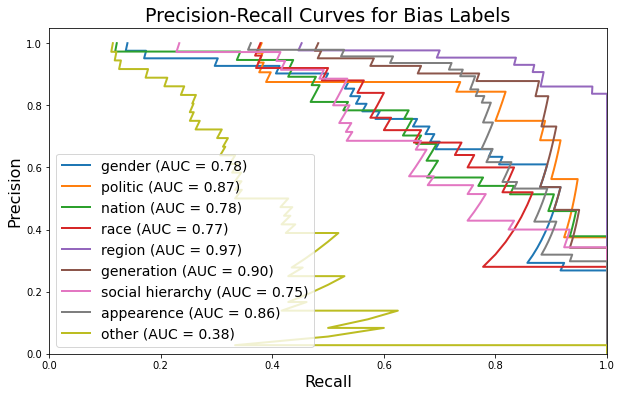


Eval results for gender.
accuracy : 92.08
precision : 58.18
recall : 78.05
f1 : 66.67
matthews_corrcoef : 63.15
pr_auc : 0.7834224292547514
roc_auc : 0.9426190956124438

Eval results for politic.
accuracy : 91.34
precision : 47.46
recall : 87.5
f1 : 61.54
matthews_corrcoef : 60.54
pr_auc : 0.8661137940052852
roc_auc : 0.9796706989247312

Eval results for nation.
accuracy : 90.59
precision : 49.18
recall : 81.08
f1 : 61.22
matthews_corrcoef : 58.51
pr_auc : 0.7794586670415715
roc_auc : 0.9503645334708005

Eval results for race.
accuracy : 89.85
precision : 37.5
recall : 96.0
f1 : 53.93
matthews_corrcoef : 56.38
pr_auc : 0.7743294849609695
roc_auc : 0.9791029023746702

Eval results for region.
accuracy : 97.77
precision : 86.96
recall : 93.02
f1 : 89.89
matthews_corrcoef : 88.7
pr_auc : 0.9672333757717702
roc_auc : 0.9938800489596084

Eval results for generation.
accuracy : 95.79
precision : 74.0
recall : 90.24
f1 : 81.32
matthews_corrcoef : 79.47
pr_auc : 0.8998006141536566
roc_auc : 0

epoch: 11, valid loss: 10.519: 100%|██████████| 101/101 [00:09<00:00, 11.12it/s]


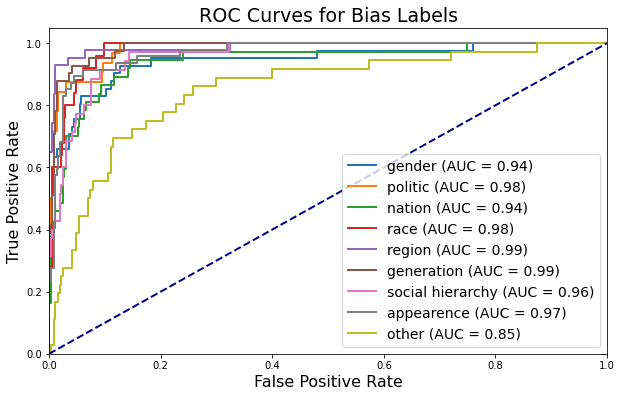

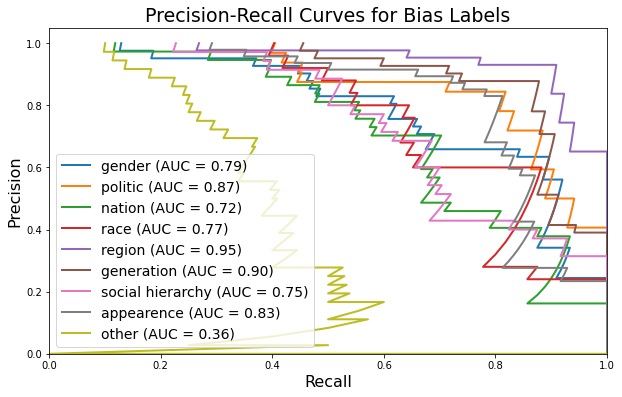


Eval results for gender.
accuracy : 92.82
precision : 61.11
recall : 80.49
f1 : 69.47
matthews_corrcoef : 66.29
pr_auc : 0.7899485206337445
roc_auc : 0.943895719948935

Eval results for politic.
accuracy : 91.34
precision : 47.46
recall : 87.5
f1 : 61.54
matthews_corrcoef : 60.54
pr_auc : 0.8659696272614434
roc_auc : 0.9820228494623655

Eval results for nation.
accuracy : 92.08
precision : 54.55
recall : 81.08
f1 : 65.22
matthews_corrcoef : 62.47
pr_auc : 0.7230397412268169
roc_auc : 0.9432947934310332

Eval results for race.
accuracy : 92.57
precision : 45.1
recall : 92.0
f1 : 60.53
matthews_corrcoef : 61.38
pr_auc : 0.7692174505679481
roc_auc : 0.9797361477572559

Eval results for region.
accuracy : 97.52
precision : 85.11
recall : 93.02
f1 : 88.89
matthews_corrcoef : 87.61
pr_auc : 0.9470912350761067
roc_auc : 0.9878889389937512

Eval results for generation.
accuracy : 95.79
precision : 74.0
recall : 90.24
f1 : 81.32
matthews_corrcoef : 79.47
pr_auc : 0.8979425142509616
roc_auc : 0

epoch: 12, valid loss: 11.2885: 100%|█████████| 101/101 [00:09<00:00, 11.11it/s]


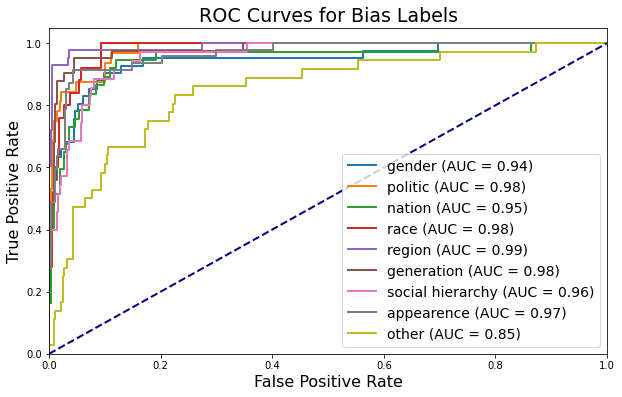

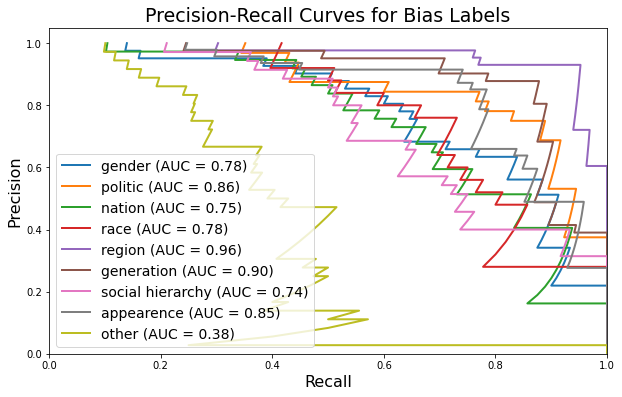


Eval results for gender.
accuracy : 91.83
precision : 56.67
recall : 82.93
f1 : 67.33
matthews_corrcoef : 64.34
pr_auc : 0.7845855070835257
roc_auc : 0.9447020090035612

Eval results for politic.
accuracy : 92.08
precision : 50.0
recall : 87.5
f1 : 63.64
matthews_corrcoef : 62.5
pr_auc : 0.8630215606905208
roc_auc : 0.980426747311828

Eval results for nation.
accuracy : 91.58
precision : 52.54
recall : 83.78
f1 : 64.58
matthews_corrcoef : 62.2
pr_auc : 0.7516787658627654
roc_auc : 0.9465350909492598

Eval results for race.
accuracy : 92.57
precision : 45.1
recall : 92.0
f1 : 60.53
matthews_corrcoef : 61.38
pr_auc : 0.7756139750569533
roc_auc : 0.9804749340369393

Eval results for region.
accuracy : 97.77
precision : 86.96
recall : 93.02
f1 : 89.89
matthews_corrcoef : 88.7
pr_auc : 0.9576950149022404
roc_auc : 0.9905301810217096

Eval results for generation.
accuracy : 96.53
precision : 78.72
recall : 90.24
f1 : 84.09
matthews_corrcoef : 82.4
pr_auc : 0.8955888231528369
roc_auc : 0.981

epoch: 13, valid loss: 11.6276: 100%|█████████| 101/101 [00:08<00:00, 11.28it/s]


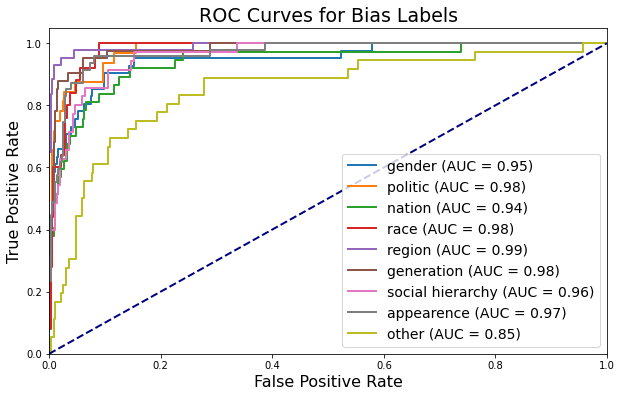

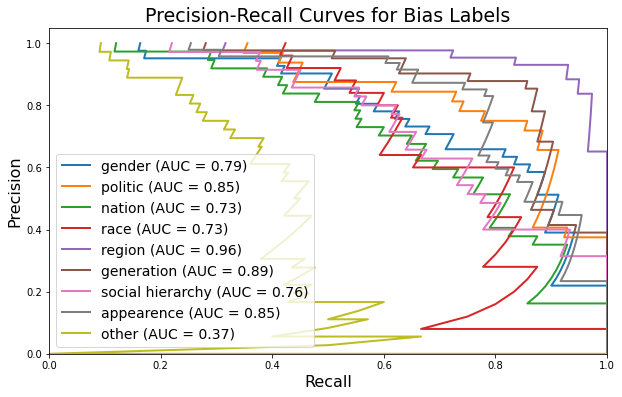


Eval results for gender.
accuracy : 91.83
precision : 56.9
recall : 80.49
f1 : 66.67
matthews_corrcoef : 63.38
pr_auc : 0.7895403661581732
roc_auc : 0.9482631189948263

Eval results for politic.
accuracy : 92.82
precision : 52.83
recall : 87.5
f1 : 65.88
matthews_corrcoef : 64.62
pr_auc : 0.850142781892398
roc_auc : 0.9795866935483871

Eval results for nation.
accuracy : 92.33
precision : 55.56
recall : 81.08
f1 : 65.93
matthews_corrcoef : 63.18
pr_auc : 0.7253448520851723
roc_auc : 0.941085499668606

Eval results for race.
accuracy : 92.33
precision : 44.23
recall : 92.0
f1 : 59.74
matthews_corrcoef : 60.69
pr_auc : 0.7257977132962288
roc_auc : 0.9793139841688655

Eval results for region.
accuracy : 97.52
precision : 85.11
recall : 93.02
f1 : 88.89
matthews_corrcoef : 87.61
pr_auc : 0.9623544209716219
roc_auc : 0.9913032274689171

Eval results for generation.
accuracy : 96.04
precision : 75.51
recall : 90.24
f1 : 82.22
matthews_corrcoef : 80.42
pr_auc : 0.8906081143340843
roc_auc : 0

epoch: 14, valid loss: 11.5489: 100%|█████████| 101/101 [00:08<00:00, 12.06it/s]


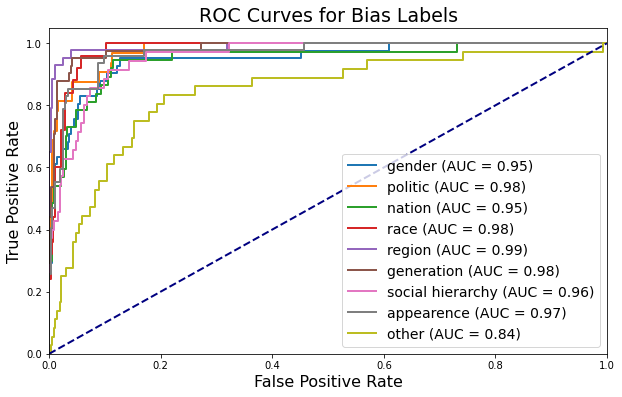

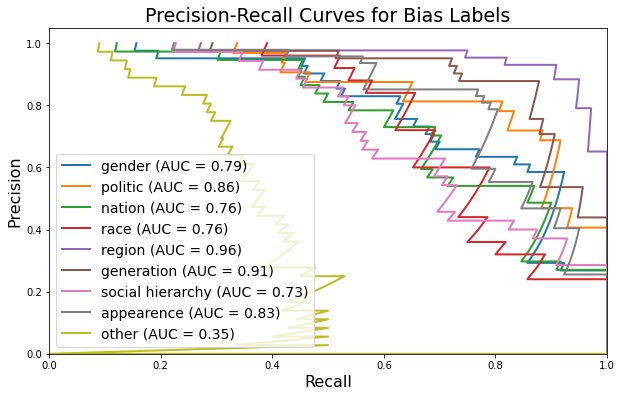


Eval results for gender.
accuracy : 92.33
precision : 58.62
recall : 82.93
f1 : 68.69
matthews_corrcoef : 65.72
pr_auc : 0.7937103604202731
roc_auc : 0.950816367667809

Eval results for politic.
accuracy : 93.56
precision : 56.0
recall : 87.5
f1 : 68.29
matthews_corrcoef : 66.91
pr_auc : 0.8576384262178853
roc_auc : 0.979502688172043

Eval results for nation.
accuracy : 91.34
precision : 51.72
recall : 81.08
f1 : 63.16
matthews_corrcoef : 60.42
pr_auc : 0.7601056288073137
roc_auc : 0.9490389572133441

Eval results for race.
accuracy : 91.83
precision : 42.86
recall : 96.0
f1 : 59.26
matthews_corrcoef : 61.05
pr_auc : 0.7640610907864607
roc_auc : 0.9811081794195251

Eval results for region.
accuracy : 98.02
precision : 88.89
recall : 93.02
f1 : 90.91
matthews_corrcoef : 89.83
pr_auc : 0.9593209035297836
roc_auc : 0.989692714037235

Eval results for generation.
accuracy : 95.54
precision : 73.47
recall : 87.8
f1 : 80.0
matthews_corrcoef : 77.91
pr_auc : 0.9066856388404634
roc_auc : 0.98

epoch: 15, valid loss: 10.277: 100%|██████████| 101/101 [00:07<00:00, 12.91it/s]


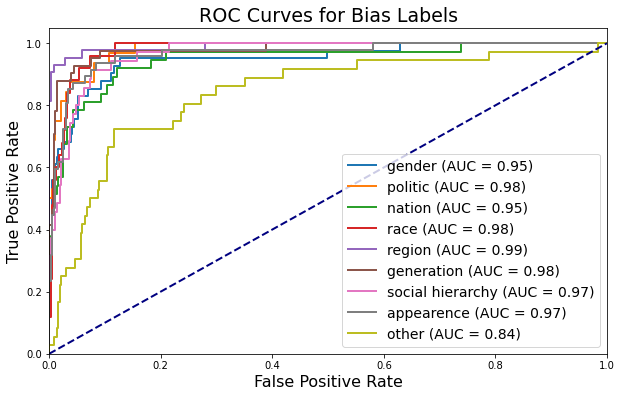

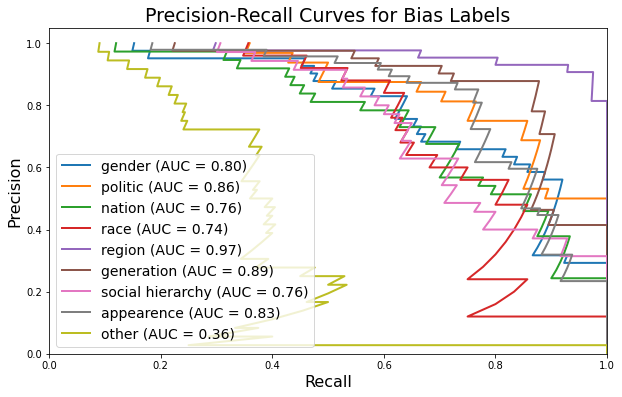


Eval results for gender.
accuracy : 92.33
precision : 58.62
recall : 82.93
f1 : 68.69
matthews_corrcoef : 65.72
pr_auc : 0.7985790480144648
roc_auc : 0.9498085063495263

Eval results for politic.
accuracy : 93.81
precision : 57.14
recall : 87.5
f1 : 69.14
matthews_corrcoef : 67.71
pr_auc : 0.8619129466634972
roc_auc : 0.9812668010752689

Eval results for nation.
accuracy : 92.57
precision : 56.6
recall : 81.08
f1 : 66.67
matthews_corrcoef : 63.92
pr_auc : 0.7614202655746657
roc_auc : 0.947197879077988

Eval results for race.
accuracy : 92.33
precision : 44.44
recall : 96.0
f1 : 60.76
matthews_corrcoef : 62.37
pr_auc : 0.7390320547051872
roc_auc : 0.9795250659630607

Eval results for region.
accuracy : 97.77
precision : 86.96
recall : 93.02
f1 : 89.89
matthews_corrcoef : 88.7
pr_auc : 0.9671192382249058
roc_auc : 0.9910455453198479

Eval results for generation.
accuracy : 96.04
precision : 76.6
recall : 87.8
f1 : 81.82
matthews_corrcoef : 79.84
pr_auc : 0.8925202781739594
roc_auc : 0.9

epoch: 16, valid loss: 11.9804: 100%|█████████| 101/101 [00:07<00:00, 12.74it/s]


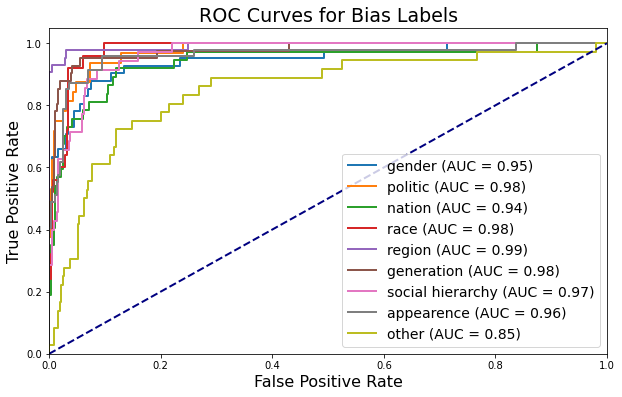

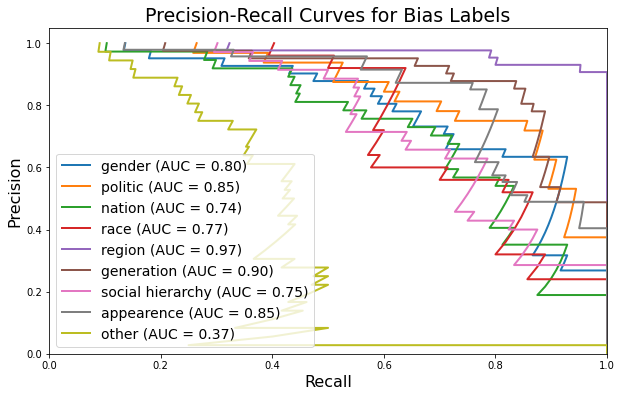


Eval results for gender.
accuracy : 92.57
precision : 60.0
recall : 80.49
f1 : 68.75
matthews_corrcoef : 65.54
pr_auc : 0.7994078006008832
roc_auc : 0.9457770610763959

Eval results for politic.
accuracy : 95.05
precision : 65.0
recall : 81.25
f1 : 72.22
matthews_corrcoef : 70.06
pr_auc : 0.8503361331202732
roc_auc : 0.9774025537634409

Eval results for nation.
accuracy : 90.84
precision : 50.0
recall : 81.08
f1 : 61.86
matthews_corrcoef : 59.14
pr_auc : 0.7416451560098386
roc_auc : 0.9400544959128065

Eval results for race.
accuracy : 93.32
precision : 48.0
recall : 96.0
f1 : 64.0
matthews_corrcoef : 65.22
pr_auc : 0.7670978849357071
roc_auc : 0.9808970976253297

Eval results for region.
accuracy : 98.51
precision : 93.02
recall : 93.02
f1 : 93.02
matthews_corrcoef : 92.19
pr_auc : 0.9736037964036308
roc_auc : 0.9927204792887973

Eval results for generation.
accuracy : 95.79
precision : 75.0
recall : 87.8
f1 : 80.9
matthews_corrcoef : 78.86
pr_auc : 0.8954853465523739
roc_auc : 0.977

In [19]:
def do_eval(epoch):
    # No gradient computation during evaluation
    with torch.no_grad():
        # Run one epoch without training (inference only)
        results = run_epoch(loader=predict_dataloader, epoch=epoch, is_train=False, **params)["result"]
        
        # Group results by category
        all_results = [ [result_dict[f'results_{i}'] for result_dict in results] for i in range(1, 10) ]
        all_results = [ [item for sublist in result_list for item in sublist] for result_list in all_results ]
        
        # Extract probabilities from results
        probs = [ [result['prob'] for result in results] for results in all_results ]
        all_probs = []
        for p in probs:
            tensors = []
            for t in p:
                if isinstance(t, torch.Tensor):
                    tensors.append(t.view(1, -1))
                else:
                    tensors.append(torch.tensor([[t]]))
            all_probs.append(torch.cat(tensors))
        
        # Evaluate the model using the evaluation data
        eval_results = eval_cls(
            config=config,
            model=model,
            loader=predict_dataloader,
            tokenizer=model.tokenizer,
            all_results=all_results,
            all_probs=all_probs,
        )
        
        category_labels = {
            1: "gender",
            2: "politic",
            3: "nation",
            4: "race",
            5: "region",
            6: "generation",
            7: "social Class",
            8: "appearance",
            9: "oher",
        }
        
        # Print evaluation results by category
        for i in range(1, 10):
            label_name = category_labels.get(i, f"Category {i}")
            print(f"\nEval results for {label_name}.")
            for k, v in eval_results[f"results_{i}"].items():
                print(f"{k} : {v}")
            
    return [eval_results[f"results_{i}"] for i in range(1, 10)] +  [eval_results[f"pr_auc_{i}"] for i in range(1, 10)]

                                                                    
train_losses = []
val_f1 = []
val_roc_auc= []
val_accuracy = []
val_pr_auc = []
best_avg_score = 0
                                                                    
if config.do_train:
    # Start training over a number of epochs
    for epoch in range(config.num_train_epochs):
        train_results = run_epoch(loader=train_dataloader, epoch=epoch, is_train=True, **params)
        train_loss = train_results['loss']
        train_losses.append(train_loss)
        
        # Optionally evaluate model during training
        if config.do_eval_during_train:
            eval_results = do_eval(epoch)
            
            # Store evaluation metrics
            val_f1.append(tuple(eval_results[i]["f1"] for i in range(9)))
            val_roc_auc.append(tuple(eval_results[i]["roc_auc"] for i in range(9)))
            val_accuracy.append(tuple(eval_results[i]["accuracy"] for i in range(9)))
            val_pr_auc.append(tuple(eval_results[-9:]))
                          
            # Check and store best model based on F1 score
            current_score = [eval_results[i]["f1"] for i in range(9)]
            current_avg_score = sum(current_score) / len(current_score)  # 평균 f1 score 기준으로 best model 정의
            if current_avg_score >= best_avg_score:
                best_avg_score = current_avg_score
                output_dir = os.path.join(config.output_dir, config.task, config.dataset, f"{epoch}-best-ckpt")
                if not os.path.exists(output_dir):
                    os.makedirs(output_dir)
                # Save the best model
                model_path = os.path.join(output_dir, "model_weights.pth")
                torch.save(model.state_dict(), model_path)
                with open(os.path.join(output_dir, "finetune_config.json"), "w") as save_config:
                    json.dump(vars(config), save_config, sort_keys=True, indent=4)
                print(f"Checkpoint {output_dir} saved.")                    

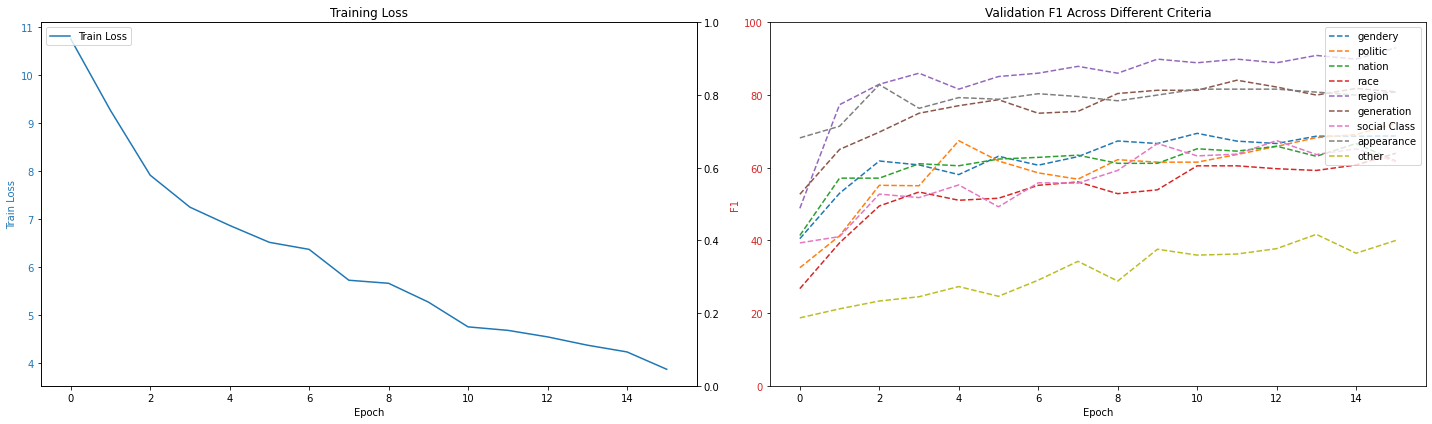

In [20]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax3) = plt.subplots(figsize=(20, 6), ncols=2)

# --- Plot Training Losses on the left plot ---
color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Train Loss', color=color)
ax1.plot(train_losses, color=color, label='Train Loss')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title("Training Loss")

# Create a second y-axis for the F1 scores in the left plot (if needed for other metrics)
ax2 = ax1.twinx()  
color = 'tab:red'
# You can plot other metrics here on ax2 if needed

# --- Plot F1 scores on the right plot ---
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1', color=color)
ax3.set_title("Validation F1 Across Different Criteria")

if config.do_eval_during_train:
    # Unzip the val_accuracies list to obtain individual score lists for each evaluation criterion
    val_scores = list(zip(*val_f1))
    labels = [
        "gendery",
        "politic",
        "nation",
        "race",
        "region",
        "generation",
        "social Class",
        "appearance",
        "other"
    ]
    for idx, label in enumerate(labels):
        ax3.plot(val_scores[idx], label=label, linestyle='--')

    ax3.tick_params(axis='y', labelcolor=color)
    ax3.set_ylim(0, 100)

# Display the legends
ax1.legend(loc='upper left')
ax3.legend(loc='upper right')

plt.tight_layout()
plt.show()

### Inference

In [21]:
from transformers import AutoModel, AutoConfig, AutoTokenizer
import torch
import os

MODEL_PATH = output_dir # best model path

model = ClsModel()
loaded_state_dict = torch.load(os.path.join(MODEL_PATH, "model_weights.pth"))
model.load_state_dict(loaded_state_dict)
model.eval() 
tokenizer = model.tokenizer

def predict(text):
    encoding = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {
        "input_ids": encoding["input_ids"],
        "attention_mask": encoding["attention_mask"],
        "token_type_ids": encoding["token_type_ids"]
    }
    with torch.no_grad():
        logits = model(inputs)

    probs = [torch.sigmoid(logit) for logit in logits]
    predictions = [(prob > 0.4).int() for prob in probs]

    return predictions

In [24]:
text = "동남아는 똥남아가 아니라 갓남아임. 국결은 동남아인이랑 해도 성공임"

results = predict(text)
labels = ["Gender", "Politics", "Nation", "Race", "Region", "Generation", "Social Hierarchy", "Appearance", "Others"]

for i in range(len(results)):
    print(f'{labels[i]}: {results[i].item()}')

Gender: 0
Politics: 0
Nation: 1
Race: 1
Region: 0
Generation: 0
Social Hierarchy: 0
Appearance: 0
Others: 0
